This file is part of DPSE 

Copyright (C) 2025 ArtiMinds Robotics GmbH

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Generate synthetic datasets for probe search

A synthetic dataset is created, which consists of a number of individual probing motions onto a simulated surface. The poses of holes on the surface is sampled from a probability distribution for each training example. This probability distribution defines the task. The meta-training dataset consists of a large number of tasks, for each of which a number of training examples are sampled.
A meta-test dataset is generated analogously.

In [ ]:
from pathlib import Path
import os
import json
import shutil

from meta_learning_experiments.experiments.spike.generate_data_mlrc import generate_meta_train_data

NB_DIR = Path(os.path.abspath(os.path.dirname("__file__")))
OUTPUT_DIR = NB_DIR / "output"

SYNTHETIC_DATA_DIR = OUTPUT_DIR / "synthetic_data"
SYNTHETIC_CONTACT_TRAIN_DATA_DIR = SYNTHETIC_DATA_DIR / "contact_train"
SYNTHETIC_CONTACT_TEST_DATA_DIR = SYNTHETIC_DATA_DIR / "contact_test"
HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR = SYNTHETIC_DATA_DIR / "contact_hole_distributions_train"
HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR = SYNTHETIC_DATA_DIR / "contact_hole_distributions_test"

TRAINED_CONTACT_MODEL_OUTPUT_DIR = OUTPUT_DIR / "trained_contact_models"

OPTIMIZATION_RESULTS_DIR = OUTPUT_DIR / "optimization_results"

CLEAR_DATA = True
CLEAR_MODELS = True
CLEAR_OPTIMIZATIONS = True
DEBUG = True
GENERATE_DATA = True
TRAIN_MODELS = True
RUN_OPTIMIZATION = True

if CLEAR_DATA:
    if SYNTHETIC_DATA_DIR.exists():
        shutil.rmtree(SYNTHETIC_DATA_DIR.as_posix())

if not SYNTHETIC_CONTACT_TRAIN_DATA_DIR.exists():
    SYNTHETIC_CONTACT_TRAIN_DATA_DIR.mkdir(parents=True)
if not SYNTHETIC_CONTACT_TEST_DATA_DIR.exists():
    SYNTHETIC_CONTACT_TEST_DATA_DIR.mkdir(parents=True)
if not HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR.exists():
    HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR.mkdir(parents=True)
if not HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR.exists():
    HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR.mkdir(parents=True)

NUM_CONTACT_TRAIN_TASKS = 1000
NUM_CONTACT_TEST_TASKS = 10
NUM_EXAMPLES_PER_CONTACT_TASK = 128

with open(NB_DIR / "config" / "experiment_config_real.json") as experiment_config_file:
    experiment_config = json.load(experiment_config_file)

if GENERATE_DATA:
    generate_meta_train_data(NUM_CONTACT_TRAIN_TASKS, NUM_EXAMPLES_PER_CONTACT_TASK, SYNTHETIC_CONTACT_TRAIN_DATA_DIR, HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR, experiment_config, debug=False)

    generate_meta_train_data(NUM_CONTACT_TEST_TASKS, NUM_EXAMPLES_PER_CONTACT_TASK, SYNTHETIC_CONTACT_TEST_DATA_DIR, HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR, experiment_config, debug=False)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np


# Function to plot an ellipse representing a Gaussian
def plot_gaussian(ax, mean, cov, weight, color):
    # Eigen decomposition of covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(vals)  # 2 standard deviations for 95% confidence
    
    # Scale the size of the ellipse by the weight
    scale = np.sqrt(weight)
    width *= scale
    height *= scale

    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, alpha=0.5, color=color)
    ax.add_patch(ellipse)
    return mean, width, height

def plot_xy(ax, hole_distribution_data: dict, hole_centers: np.ndarray, sim: np.ndarray, real: np.ndarray):
    # Define colors for the components
    colors = plt.cm.viridis(np.linspace(0, 1, len(hole_distribution_data["means"])))

    # Plot each Gaussian component
    for mean, cov, weight, color in zip(hole_distribution_data["means"], hole_distribution_data["covs"], hole_distribution_data["weights"], colors):
        m, w, h = plot_gaussian(ax, mean, cov, weight, color)
        ax.scatter(*mean, color=color, s=50, label=f"Weight: {weight:.2f}")

    # Plot the hole centers
    ax.scatter(hole_centers[:, 0], hole_centers[:, 1], color="black", marker="x")

    # Plot the motions
    for sim_motion in sim:
        ax.scatter(sim_motion[:, 2], sim_motion[:, 3], color="green" if sim_motion[-1,1] > 0.5 else "red", alpha=0.5)
    for real_motion in real:
        ax.scatter(real_motion[:, 2], real_motion[:, 3], color="green" if real_motion[-1,1] > 0.5 else "red")

    ax.set_title("Simulated contact motions, top-down view [XY axis]")
    ax.set_xlabel("Position (X)")
    ax.set_ylabel("Position (Y)")
    ax.legend()
    ax.grid(True)

def plot_z(ax, sim: np.ndarray, real: np.ndarray):
    for sim_motion in sim:
        ax.plot(range(sim_motion.shape[0]), sim_motion[:, 4], color="green" if sim_motion[-1,1] > 0.5 else "red", alpha=0.5,
                linestyle="dashed")
    for real_motion in real:
        ax.plot(range(real_motion.shape[0]), real_motion[:, 4], color="green" if real_motion[-1,1] > 0.5 else "red")

    ax.set_title("Simulated contact motions [Z axis]")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Position (Z)")
    ax.legend()
    ax.grid(True)

def plot_fz(ax, sim: np.ndarray, real: np.ndarray):
    for sim_motion in sim:
        ax.plot(range(sim_motion.shape[0]), sim_motion[:, 2+7+2], color="green" if sim_motion[-1,1] > 0.5 else "red", alpha=0.5,
                linestyle="dashed")
    for real_motion in real:
        ax.plot(range(real_motion.shape[0]), real_motion[:, 2+7+2], color="green" if real_motion[-1,1] > 0.5 else "red")

    ax.set_title("Simulated contact motions [force along Z axis]")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Force (Z)")
    ax.legend()
    ax.grid(True)

In the following visualization of the training data, note that there are two groups of trajectories for each task: One group of trajectories stops at a higher position on the Z axis, indicating that the robot stopped on contact with the surface, while another set stops at a lower position along the Z axis, indicating that teh end effector dropped into a hole. The same groups are visible in the simulated force data, in which trajectories that make contact with the surface eventually build up a nonzero force along the Z axis, while trajectories for which the end-effector dropped into a hole have zero forces throughout.
Note that the trajectories contain simulated encoder and force-torque sensor noise, and that the height of the simulated surface varies slightly for each execution, to mimic a realistic, noisy execution setting.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

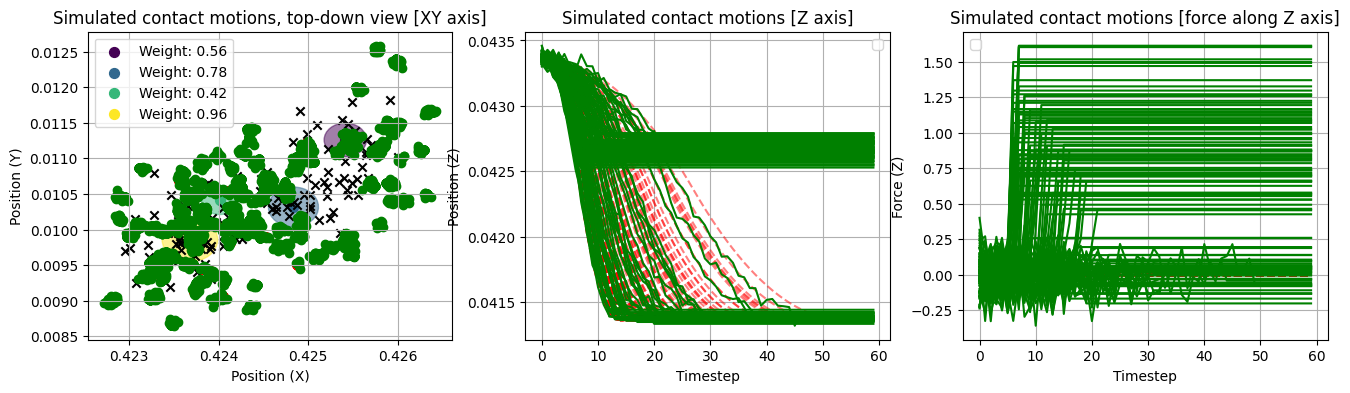

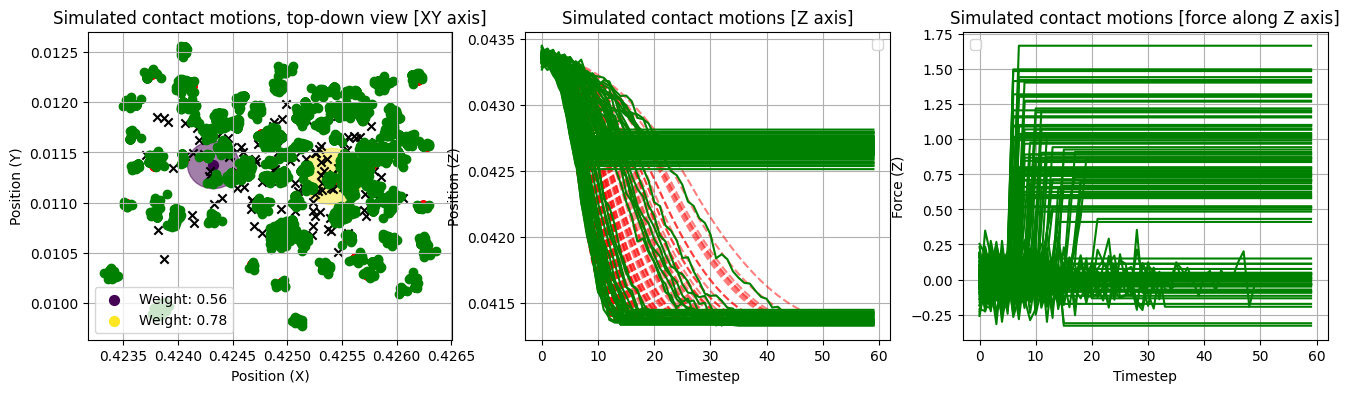

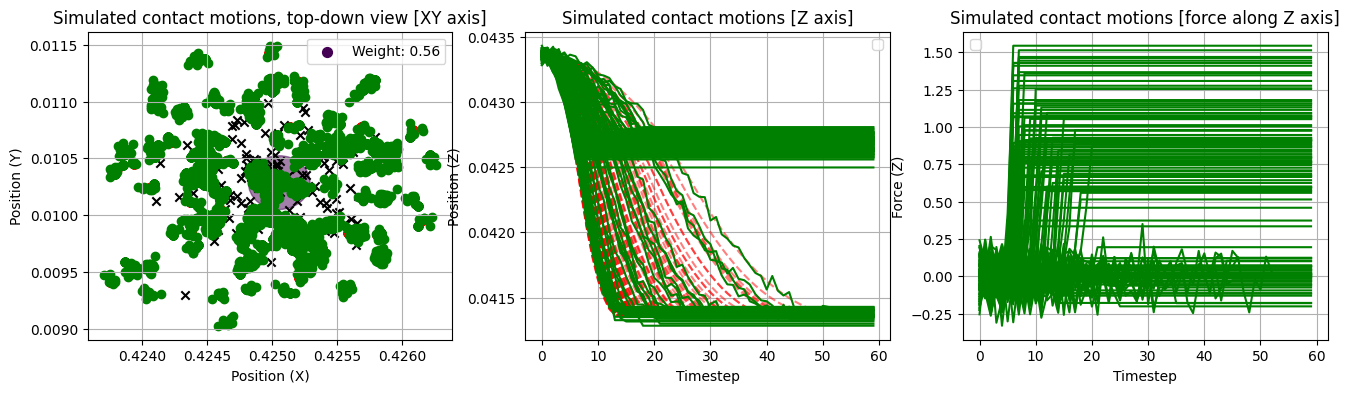

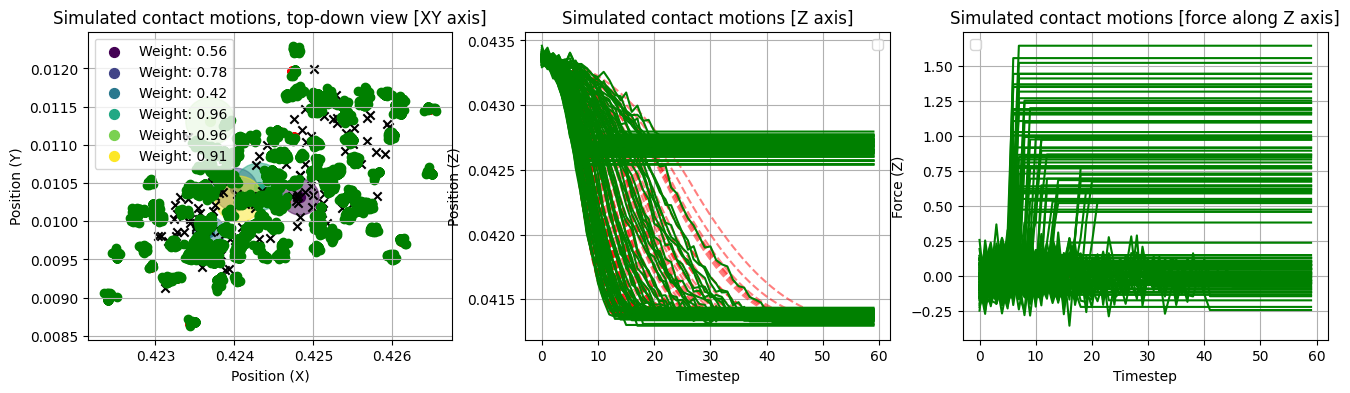

In [4]:
import itertools
import h5py

N_DATA_TO_PLOT = 4

# Plot some contact motion training data
for hole_distribution_dir, probe_filepath in zip(
    itertools.islice(HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR.glob("*"), N_DATA_TO_PLOT),
    itertools.islice(SYNTHETIC_CONTACT_TRAIN_DATA_DIR.glob("*"), N_DATA_TO_PLOT)):

    with open(hole_distribution_dir / "hole_distribution.json") as hole_distribution_json:
        hole_distribution_data = json.load(hole_distribution_json)
    
    with h5py.File(probe_filepath, "r") as f:
        hole_centers_group = f.get("hole_centers")
        hole_centers = np.concatenate([hole_centers_group[key][:] for key in hole_centers_group.keys()])

        sim_group = f.get("sim")
        sim = np.concatenate([sim_group[key][:] for key in sim_group.keys()])

        real_group = f.get("real")
        real = np.concatenate([real_group[key][:] for key in real_group.keys()])

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
        plot_xy(axes[0], hole_distribution_data, hole_centers, sim, real)
        plot_z(axes[1], sim, real)
        plot_fz(axes[2], sim, real)
    

## Model training

A Shadow Skill for individual contact motions ("Move Linear Relative Contact") is trained on the synthetic meta-train dataset.
Multiple (identical) copies of the trained contact motion skill are combined to form a probe search skill.

In [5]:
from meta_learning_experiments.experiments.spike.spike_search import SpikeSearch
from spi.neural_templates.program_primitive import ProgramPrimitive
from graphmodel.graphmodel.graph_node_move_linear_relative_contact import GraphNodeMoveLinearRelativeContact
from spi.simulation.static_simulator import StaticSimulator
from spi.neural_templates.models.seq2seq.model import ResidualGRU
import torch

NUM_PROBES_PER_SEARCH = 16

contact_limits_x = torch.tensor(experiment_config["mlrc"]["limits_x"], dtype=torch.float32)
contact_limits_s = torch.tensor(experiment_config["mlrc"]["limits_s"], dtype=torch.float32)
contact_limits_Y = torch.tensor(experiment_config["mlrc"]["limits_Y"], dtype=torch.float32) 

with open(NB_DIR / "config" / "model_config_mlrc.json") as contact_model_config_file:
    contact_model_config = json.load(contact_model_config_file)

contact_simulator = StaticSimulator(GraphNodeMoveLinearRelativeContact(), experiment_config["sampling_interval"], multiproc=False)

contact_model = ResidualGRU(static_input_size=7+2+2, sequence_input_size=2+7+6, environment_embedding_size=None, hidden_size=contact_model_config["hidden_size"], output_size=2+7+6, num_layers=contact_model_config["num_layers"], dropout_p=contact_model_config["dropout_p"])
contact_skill = ProgramPrimitive("Move Linear Relative Contact", 11, contact_limits_x,
                                                                     contact_limits_s, contact_limits_Y, contact_simulator,
                                                                     contact_model_config,
                                                                     contact_model)
probe_skill = SpikeSearch(NUM_PROBES_PER_SEARCH, contact_skill, experiment_config)

ResidualGRU, total number of parameters: 567739


In [6]:
# Train MLRC

from spi.neural_programs.train_program_component_sgd import train_sgd

if CLEAR_MODELS:
    if TRAINED_CONTACT_MODEL_OUTPUT_DIR.exists():
        shutil.rmtree(TRAINED_CONTACT_MODEL_OUTPUT_DIR.as_posix())
        
if not TRAINED_CONTACT_MODEL_OUTPUT_DIR.exists():
    TRAINED_CONTACT_MODEL_OUTPUT_DIR.mkdir(parents=True)

if TRAIN_MODELS:
    train_sgd(contact_skill, SYNTHETIC_CONTACT_TRAIN_DATA_DIR, TRAINED_CONTACT_MODEL_OUTPUT_DIR, invert_success_label=True)

In [7]:
from meta_learning_experiments.experiments.spike.test_mlrc import finetune_and_test

# Test trained contact model
model_dir = list(sorted(TRAINED_CONTACT_MODEL_OUTPUT_DIR.glob("*")))[-1]    # Assume newest model is last when sorted

if TRAIN_MODELS:
    finetune_and_test(model_dir, SYNTHETIC_CONTACT_TEST_DATA_DIR, experiment_config,
                    samples_per_task=NUM_EXAMPLES_PER_CONTACT_TASK, adapt_steps=128,
                    learning_rate=5e-4, show=False, mc_dropout=False)

## Robot program parameter optimization

Using Shadow Program Inversion (first-order differentiable parameter optimization over a learned surrogate of a robot program), the parameters of the probe search are optimited to maximize the probability of search success, subject to an additional cycle time minimization constraint. Note that before optimization, the trained contact models are finetuned on a small number of meta-test examples.

In [ ]:
from types import SimpleNamespace
from meta_learning_experiments.experiments.common_utils import MetaDataset
from meta_learning_experiments.experiments.spike.optimize_spikes import optimize_for_task
from meta_learning_experiments.experiments.spike.spike_search_tools import augment_dataset, spike_search_grid_xy_from_input_tensor

if CLEAR_OPTIMIZATIONS:
    if OPTIMIZATION_RESULTS_DIR.exists():
        shutil.rmtree(OPTIMIZATION_RESULTS_DIR.as_posix())

if not OPTIMIZATION_RESULTS_DIR.exists():
    OPTIMIZATION_RESULTS_DIR.mkdir(parents=True)

meta_test_tasks = list(SYNTHETIC_CONTACT_TEST_DATA_DIR.glob("*"))
meta_test_set = MetaDataset(meta_test_tasks)
meta_test_set = augment_dataset(MetaDataset(meta_test_tasks), experiment_config, 256)

SPI_ITERATIONS = 250        # Number of iterations of parameter optimization
# SPI_ITERATIONS = 3
SPI_LR = 5e-4
ADAPT_STEPS = 512           # Finetuning steps on the task at hand
NUM_TESTS = 1              # Number of trials (optimizations) per task. Each task has several different examples in its test data

if RUN_OPTIMIZATION:
    args = SimpleNamespace(trained_mlrc_dir=model_dir, model_type="finetune", results_dir=OPTIMIZATION_RESULTS_DIR, show=True)
    results_for_all_tasks = []
    for task_idx, task in enumerate(meta_test_set):
        task_results = optimize_for_task(args, experiment_config, SPI_ITERATIONS, SPI_LR, task, task_idx,
                                        adapt_steps=ADAPT_STEPS, num_tests=NUM_TESTS)
        results_for_all_tasks.append(task_results)
        if task_idx > 1:    # TODO: More tasks!
            break
    torch.save(OPTIMIZATION_RESULTS_DIR / "results.pt", results_for_all_tasks)
else:
    results_for_all_tasks = torch.load(OPTIMIZATION_RESULTS_DIR / "results.pt", weights_only=False)

/home/alt/DATA/dpse_minimal/spi/common/trajectory.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  success = torch.tensor(self.success_label, dtype=torch.float32).view(1, 1).repeat(base_tensor.size(0), 1)


/tmp/tmpz9okxvmh/0.h5 does not exist, creating...


/home/alt/DATA/dpse_minimal/.venv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


/tmp/tmpz9okxvmh/1.h5 does not exist, creating...
/tmp/tmpz9okxvmh/2.h5 does not exist, creating...
/tmp/tmpz9okxvmh/3.h5 does not exist, creating...
/tmp/tmpz9okxvmh/4.h5 does not exist, creating...
/tmp/tmpz9okxvmh/5.h5 does not exist, creating...
/tmp/tmpz9okxvmh/6.h5 does not exist, creating...
/tmp/tmpz9okxvmh/7.h5 does not exist, creating...
/tmp/tmpz9okxvmh/8.h5 does not exist, creating...
/tmp/tmpz9okxvmh/9.h5 does not exist, creating...


The optimized search patterns approximate the hole distribution. Note that the "knowledge" about the hole distribution is entirely implicit in the weights of the shadow model: The model has learned to predict task success, and the meta-test data contains evidence that probing motions in certain locations have a higher probability of success than others. Through shadow program inversion, this latent knowledge leads to the optimizer "pulling" the probe points closer to the expected hole positions.

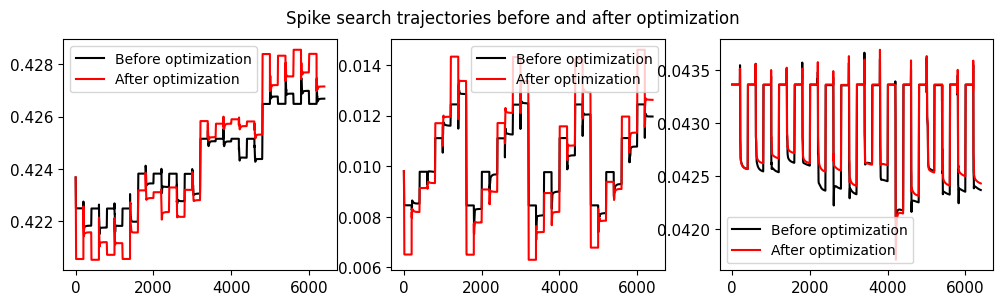

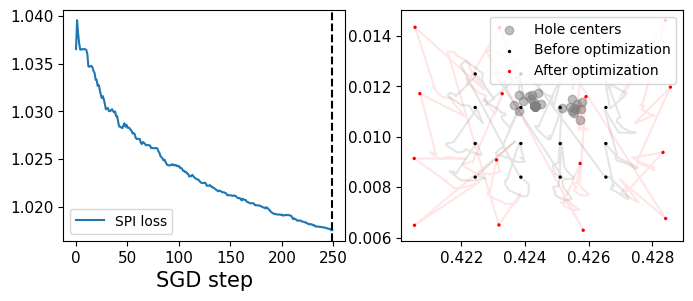

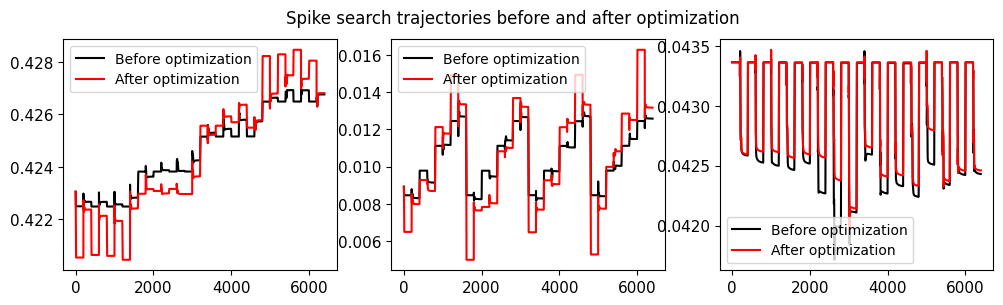

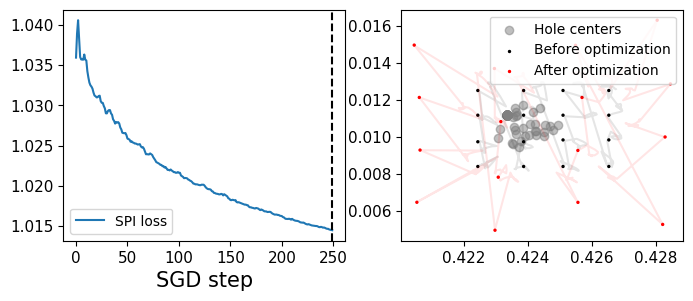

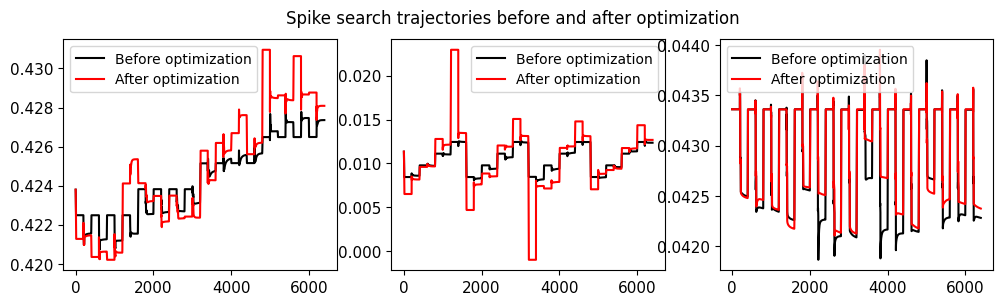

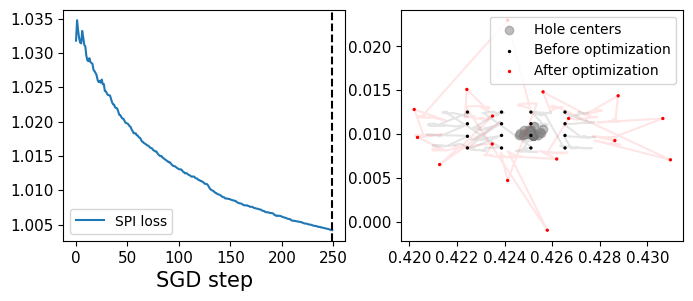

In [15]:
NUM_TASKS_TO_PLOT = 3
NUM_TRIALS_TO_PLOT_PER_TASK = 1

for task_results in results_for_all_tasks[:NUM_TASKS_TO_PLOT]:
    for trial in task_results[:NUM_TRIALS_TO_PLOT_PER_TASK]:
        losses = trial["loss"]
        Ys = trial["Y"]
        xs = trial["x"]
        test_hole_centers = trial["hole_centers"]

        min_loss_idx = np.argmin(losses)
        initial_x = xs[0][0]
        initial_grid_xy = spike_search_grid_xy_from_input_tensor(initial_x.unsqueeze(0))
        initial_Y = Ys[0][0]
        best_Y = Ys[min_loss_idx][0]
        best_x = xs[min_loss_idx][0]
        final_grid_xy = spike_search_grid_xy_from_input_tensor(best_x.unsqueeze(0))


        # Plot trajcetories along X, Y and Z axis to validate plausibility
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
        fig.suptitle("Spike search trajectories before and after optimization")
        for dim in range(3):
            ax[dim].plot(range(len(initial_Y)), initial_Y[:, 2+dim], color="black", label="Before optimization")
            ax[dim].plot(range(len(best_Y)), best_Y[:, 2+dim], color="red", label="After optimization")
            ax[dim].legend(prop={'size': 10})
        plt.show()

        # Optimization loss and top-down view on search
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        ax[0].plot(range(len(losses)), losses, label="SPI loss")
        ax[0].axvline(x=min_loss_idx, color="black", linestyle="--")
        ax[0].set_xlabel("SGD step")
        ax[0].legend(prop={'size': 10})

        ax[1].scatter(test_hole_centers[:, 0].cpu(), test_hole_centers[:, 1].cpu(), color="gray", alpha=0.5,
                        label="Hole centers")
        ax[1].plot(initial_Y[:, 2], initial_Y[:, 3], color="black", alpha=0.1)
        ax[1].scatter(initial_grid_xy[0,:,0], initial_grid_xy[0,:,1], color="black", s=[2 for _ in range(final_grid_xy.shape[1])],
                        label="Before optimization")
        ax[1].plot(best_Y[:, 2], best_Y[:, 3], color="red", alpha=0.1)
        ax[1].scatter(final_grid_xy[0,:,0], final_grid_xy[0,:,1], color="red", s=[2 for _ in range(final_grid_xy.shape[1])],
                        label="After optimization")
        ax[1].legend(prop={'size': 10})